In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 10 # 25 # 50
d_H = 2 # 10
width = 1024  # 1024
bias = False
n_steps = 10000
base_lr = 5.0e-3

target_p = 2
SEED = 42
num = 500
N_b = 1000

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/1d/{}'.format(width))

In [8]:
set_random_seeds(SEED)
key = jax.random.PRNGKey(SEED)

# 1. Initial Density $\tau_0$

If $X \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2} \right)$, then we have that $Y = \arccos \left(\sqrt{X} \right) \sim \tau_0$ where $$d\tau_0(\theta) = \frac{2}{B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right)} \cos(\theta)^{d_H - 1} \sin(\theta)^{d_\perp - 1} d\theta$$

In [9]:
@jit
def tau_0_density(theta, d_H=d_H, input_dim=input_dim):
    d = input_dim
    return 2 * (jnp.cos(theta) ** (d_H - 1)) * (jnp.sin(theta) ** (d-d_H -1)) / s.beta(d_H/2, (d-d_H)/2)

In [10]:
m = width 
d = input_dim

initial_cs = jnp.sign(jax.random.uniform(key=key, minval=-1., maxval=1.0, shape=[width]))
initial_thetas = jnp.arccos(jnp.sqrt(jax.random.beta(key, d_H/2, (d-d_H)/2, shape=[width])))
signs = jnp.copy(initial_cs)

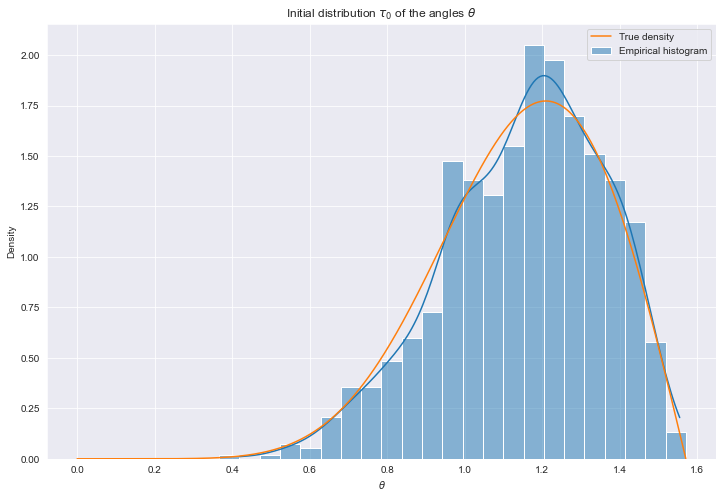

In [11]:
theta_grid = jnp.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\theta$'])
data['$\\theta$'] = initial_thetas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\theta$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

### 1.1 Other distributions test

In [12]:
omegas = jnp.arccos(jnp.sqrt(jax.random.beta(key, d_H/2, (d-d_H)/2, shape=[N_b])))
qs = jnp.sqrt(jax.random.beta(key, 1/2, (d_H - 1)/2, shape=[1, 2*N_b]))
vs = jnp.sqrt(jax.random.beta(key, 1/2, (d-d_H-1)/2, shape=[1, 2*N_b]))
bernouillis = jnp.sign(jax.random.uniform(key, minval=-1., maxval=1.0, shape=[2, 2*N_b]))
rs = (qs * bernouillis[0, :]).reshape(-1)
us = (vs * bernouillis[1, :]).reshape(-1)

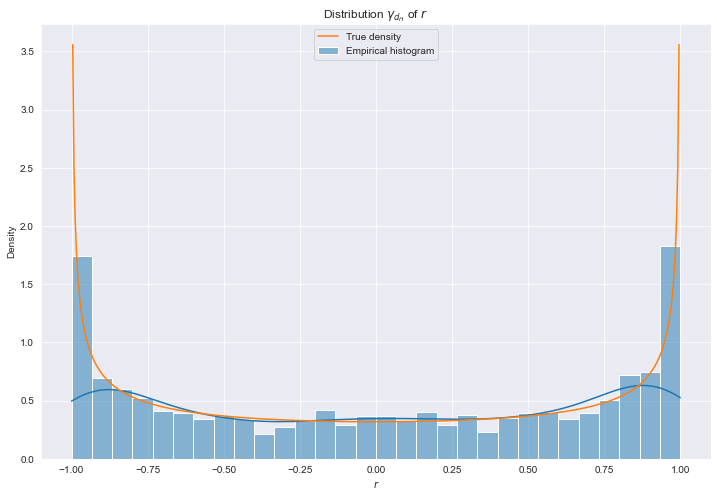

In [13]:
u_grid = jnp.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$r$'])
data['$r$'] = rs

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$r$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d_H-3)/2) / s.beta(1/2, (d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_H}$ of $r$')
plt.legend()
plt.show()

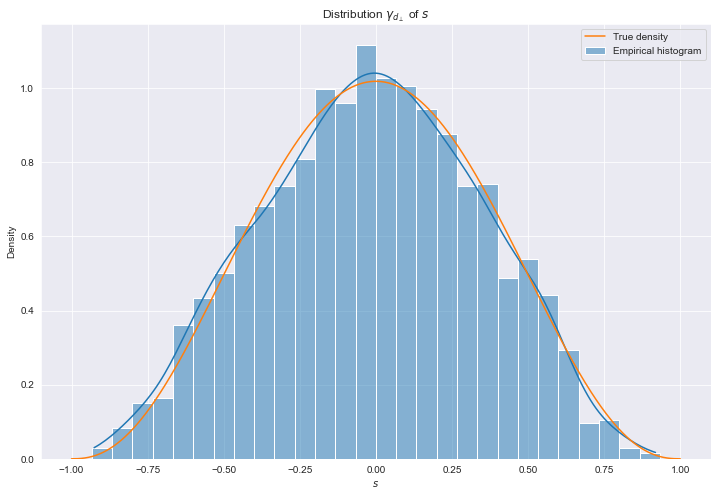

In [14]:
r_grid = jnp.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['s$'])
data['$s$'] = us

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$s$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d-d_H-3)/2) / s.beta(1/2, (d-d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_\perp}$ of $s$')
plt.legend()
plt.show()

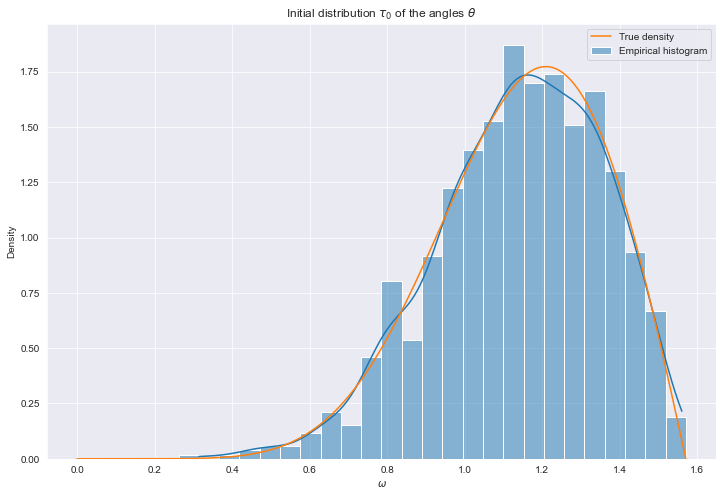

In [15]:
theta_grid = jnp.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\omega$'])
data['$\\omega$'] = omegas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\omega$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

## 1.A. Tests at initialization

### A.I) Squared target average

In theory, the initial squared loss is $(1/2) \mathbb{E}[||y_H||^2]$ because the predictor is 0. After some computation, this should be equal to $d_H/2$. An integral appearing in this computation is 
\begin{align*}
    \int_\omega \cos(\omega)^2 d\tilde{\gamma}(\omega) =& d_H/d
\end{align*}
We will check that our sampling strategy yields the correct result.

In [16]:
print('d_H/d = {:.5f}'.format(d_H/input_dim))
val = jnp.sum(jnp.cos(omegas) **2 ) / N_b
print('Estimated value via MC sampling: {:.5f}'.format(val))

d_H/d = 0.20000
Estimated value via MC sampling: 0.19971


We will compute the inital $f(\tau_{m,0}; \omega)$ for $\omega$ first in a grid line over $[0, \pi/2]$ and second for $\omega$ sampled according to the initial distribution.

# 2. Simulation of the dynamic

## 2.1 Prediction function at initialization

Consider functions parameterized by $\tau = \tau_+ - \tau_- \in \mathcal{M}([0, \pi/2])$ where $\tau_\pm \in \mathcal{M}_+([0, \pi/2])$ as 
\begin{align}
    f(\tau; x) &= |\mathbb{S}^{d_H-2}|\, |\mathbb{S}^{d_\perp-2}| \int_{\theta} \phi(\theta; x) d\tau(\theta)
\end{align}
where 
\begin{align}
    \phi(\theta; x) = \int_{r,s} \sigma \Big(\cos(\theta) ||x_H|| r +  \sin(\theta) ||x_\perp|| s\Big) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s)
\end{align}
where $d\gamma_{d_H}$ and $d\gamma_{d_\perp}$ are defined below. This can be re-written by re-parametrizing $x$ by its angle $\omega_x$ with $H$, using the positive $1$-homogeneity:
\begin{align}
    \phi(\theta; x) &= ||x|| \int_{r,s} \psi(\theta, \omega_x; r,s) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s) \\
    \psi(\theta, \omega; r,s) &= \sigma \Big(\cos(\theta) \cos(\omega)  r +  \sin(\theta) \sin(\omega) s\Big)
\end{align}

In [17]:
@jit
def psi(r, u, theta, omega):
    return jnp.maximum(jnp.cos(theta) * (jnp.cos(omega) * r) + jnp.sin(theta) * (jnp.sin(omega) * u), 0)

Approximating 
\begin{align}
    I(\theta, \omega) := \int_{r,s \in [0,1]} \sigma \Big(\cos(\theta) \cos(\omega) r + \sin(\theta) \sin(\omega) s  \Big) d\gamma_{d_H}(r) d\gamma_{d_\perp}(s)
\end{align}
with 
\begin{align}
    d\gamma_{d_H}(r) &= (1 - r^2)^{(d_H-3)/2} \\
    d\gamma_{d_\perp}(s) &= (1 - s^2)^{(d_\perp-3)/2}
\end{align}
via Monte-Carlo sampling.

Sampling $R$ from $\gamma_{d_H}$ and $S$ from $\gamma_{d_\perp}$ is simply doing
\begin{align}
    R &= \sqrt{U}, \qquad U \sim B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \\
    S &= \sqrt{V}, \qquad V \sim B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)
\end{align}
with the appropriate re-normalization, i.e., we have:
\begin{align}
    I(\theta, \omega) \simeq \frac{B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)}{N} \sum_{k=1}^N \sigma \Big(\cos(\theta) \cos(\omega) R_k + \sin(\theta) \sin(\omega) S_k  \Big)
\end{align}

## 2.2 Dynamic and approximation of the reaction and drift terms

The gradient flow equations are as follows for any pair of (weight, position) indexed by $j$:
\begin{align}
    c_j'(t) &= 2 \varepsilon_j c_j(t) G_t(\theta_j(t)) \\
    \theta_j'(t) &= \varepsilon_j V_t(\theta_j(t))
\end{align}
which induce the following discretized updates:
\begin{align}
    c_j(k+1) &= \left(1 + 2 \eta \varepsilon_j G_t(\theta_j(k)) \right) c_j(k)  \\
    \theta_j(k+1) &= \theta_j(k) + \eta \varepsilon_j V_t(\theta_j(k))
\end{align}
where $\varepsilon_j$ is the initial sign of the $j$-th particle (i.e. $\varepsilon_j = c_j(0)$), and the drift term $V_t$ and the reaction term $G_t$ are
\begin{align}
    G_t(\theta) &= d \int_{\omega} R_t(\omega) \int_{r,s} \psi(\theta, \omega; r,s) d\tilde{\gamma}(\omega) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s) \\
    V_t(\theta) &= G_t'(\theta) = d \int_{\omega} R_t(\omega) \int_{r,s} \sigma' \Big( \cos(\theta) \cos(\omega)  r +  \sin(\theta) \sin(\omega) s\Big) \Big[-\sin(\theta) \cos(\omega)  r +  \cos(\theta) \sin(\omega) s \Big] d\tilde{\gamma}(\omega) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s)
\end{align}
where 
\begin{align}
    d\tilde{\gamma}(\omega) &= d\tau_0(\omega) \\
    R_t(\omega) &= \cos(\omega) - f(\tau_{m,t}; \omega) \\
\end{align}
with the discretization
\begin{align}
    \tau_{m,t} &= \frac{1}{m} \sum_{j=1}^m c_j(t) \delta_{\theta_j(t)} \\
    f(\tau_{m,t}; \omega) &= \frac{1}{m} \sum_{j=1}^m c_j(t) \phi(\theta_j(t); \omega)
\end{align}

We rely again on Monte-Carlo sampling to estimate the integrals defining $V_t$ and $G_t$, defining $\chi = \partial_\theta \psi$:
\begin{align}
    V_t(\theta) \simeq \frac{d }{N} \sum_{i=1}^N R_t(\Omega_i) \chi(\theta, \Omega_i; R_i, S_i) \\
    G_t(\theta) \simeq \frac{d }{N} \sum_{i=1}^N R_t(\Omega_i) \psi(\theta, \Omega_i; R_i, S_i)
\end{align}
where we have sampled
\begin{align}
    \Omega_i &= \arccos(\sqrt{\Lambda_i}), \qquad \Lambda_i \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \\
    R_i &= \epsilon_i \sqrt{U_i}, \qquad U_i \sim B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \\
    S_i &= \epsilon_i \sqrt{V_i}, \qquad V_i \sim B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right) \\
    \epsilon &\sim \mathcal{U}(\{-1, 1\})
\end{align}

In [18]:
@jit
def chi(r, u, theta, omega):
    return ((1 + jnp.sign(jnp.cos(theta) * (jnp.cos(omega) * r) + jnp.sin(theta) * (jnp.sin(omega) * u)))/2 * 
            (jnp.cos(theta) * (jnp.sin(omega) * u) - jnp.sin(theta) * (jnp.cos(omega) * r)))

## 2.3 Simulating the dynamic by samling at each iteration

We follow the following procedure: $c_j(0)$ and $\theta_j(0)$ being suitably initialized, at each iteration $k$, we do:
1. draw $N_b$ samples $(\Lambda_i, U_i, V_i)$ from $B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right)$
2. compute $[R_t(\arccos(\sqrt{\Lambda_i}))]_i$ (using the pre-defined sampling for $f(\tau_{m, k})$) and append it to the list of previous residuals:
3. for every $j$ do
    * compute $[\psi(\theta_j(k), \arccos(\sqrt{\Lambda_i})); \sqrt{U_i}, \sqrt{V_i})]_i$ and $[\chi(\theta_j(k), \arccos(\sqrt{\Lambda_i})); \sqrt{U_i}, \sqrt{V_i})]_i$ in arrays,
    * compute the estimates 
    \begin{align*}
        \hat{V}_{k}(\theta_j(k)) &= \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \chi(\theta_j(k), \Omega_i; R_i, S_i) \\
        \hat{G}_k(\theta_j(k)) &= \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \psi(\theta_j(k), \Omega_i; R_i, S_i)
    \end{align*}
    * apply the updates
    \begin{align*}
        c_j(k+1) &= \left(1 + 2 \eta \hat{G}_k(\theta_j(k)) \right) c_j(k)  \\
        \theta_j(k+1) &= \theta_j(k) + \eta \hat{V}_k(\theta_j(k))
    \end{align*}
3. Add the $[c_j(k+1)]_j$ and $[\theta_j(k+1)]_j$ to the list of previous updates

To avoid having multiple different samplings, we put the termm $\cos(\omega)$ inside the integral defining $R_t(\omega)$ and thus consider $G_t$ and $V_t$ as integrals over the $5$ variables $(\omega, r, s, r', s')$. Being carefull with the constants, **and identifying, by an abuse of notation, the measures with their normalized counterparts**, we find:
\begin{align*}
    G_t(\theta) &= d \int_{\omega, r, s, r', s'} \frac{\psi(\theta, \omega; r,s)}{m} \sum_{j=1}^m \Big(\cos(\omega) - c_j  \psi(\theta_j, \omega; r', s') \Big) d\tilde{\gamma}(\omega) (d\tilde{\gamma}_{d_H}(r,r'))^2 (d\tilde{\gamma}_{d_\perp}(s,s'))^2 \\
     V_t(\theta) &= d \int_{\omega, r, s, r', s'} \frac{\chi(\theta, \omega; r,s)}{m} \sum_{j=1}^m \Big(\cos(\omega) - c_j  \psi(\theta_j, \omega; r', s') \Big) d\tilde{\gamma}(\omega) (d\tilde{\gamma}_{d_H}(r,r'))^2 (d\tilde{\gamma}_{d_\perp}(s,s'))^2
\end{align*}
Calling $\mathbf{\Psi}$ and $\mathbf{\chi}$ the matrices such that 
\begin{align*}
    \mathbf{\Psi}_{j,i} &= \psi(\theta_j, \Omega_i; R_i, S_i) \\
    \mathbf{\tilde{\Psi}}_{j,i} &= \psi(\theta_j, \Omega_i; R'_i, S'_i) \\
    \chi_{j,i} &= \chi(\theta_j, \Omega_i; R_i, S_i)
\end{align*}
we have the following update rules for the vectors $c = (c_j)_j$ and $\theta = (\theta_j)_j$:
\begin{align*}
    c(k+1) &= (1 + 2 m \eta \hat{G}_k) \odot c(k) \\
    \theta(k+1) &= \theta(k) + m \eta \hat{V}_k
\end{align*}
where 
\begin{align*}
    \hat{G}_k &= \frac{d}{N_b} \mathbf{\Psi} \left(\cos(\Omega) - \frac{1}{m} \mathbf{\tilde{\Psi}}^\top c(k) \right) \\
    \hat{V}_k &= \frac{d}{N_b} \mathbf{\chi} \left(\cos(\Omega) - \frac{1}{m} \mathbf{\tilde{\Psi}}^\top c(k) \right)
\end{align*}

As for the loss computation, it is given by 
\begin{align*}
    L_k =& \frac{2}{d} \tilde{L}_k \\
    \tilde{L}_k =& \frac{d_H}{d} - \frac{2}{N_b} \cos(\Omega)^\top \mathbf{\Psi}^\top c(k) + c(k)^\top \mathbf{\Psi} \mathbf{\tilde{\Psi}}^\top c(k)
\end{align*}

In [19]:
@jit
def train_step(key, cs_k, thetas_k):
    # sampling at step k
    keys = jax.random.split(key, num=10)
    omegas = jnp.arccos(jnp.sqrt(jax.random.beta(keys[0], d_H/2, (d-d_H)/2, shape=[1, N_b])))
    
    qs = jnp.sqrt(jax.random.beta(keys[1], 1/2, (d_H - 1)/2, shape=[2, N_b]))
    #qs_2 = jnp.sqrt(jax.random.beta(keys[2], 1/2, (d_H - 1)/2, shape=[1, N_b]))
    vs = jnp.sqrt(jax.random.beta(keys[3], 1/2, (d-d_H-1)/2, shape=[2, N_b]))
    #vs_2 = jnp.sqrt(jax.random.beta(keys[4], 1/2, (d-d_H-1)/2, shape=[1, N_b]))
    
    bernouillis = jnp.sign(jax.random.uniform(keys[5], minval=-1., maxval=1.0, shape=[4, N_b]))
    #bernouillis_us_1 = jnp.sign(jax.random.uniform(keys[6], minval=-1., maxval=1.0, shape=[N_b]))
    #bernouillis_rs_2 = jnp.sign(jax.random.uniform(keys[7], minval=-1., maxval=1.0, shape=[N_b]))
    #bernouillis_us_2 = jnp.sign(jax.random.uniform(keys[8], minval=-1., maxval=1.0, shape=[N_b]))
    
    rs = qs * bernouillis[:2, :]
    us = vs * bernouillis[2:, :]

    # matrices and vectors at step k
    psi_mat = psi(rs[[0], :], us[[0], :], thetas_k.reshape(-1, 1), omegas)
    psi_tilde_mat_T = jnp.transpose(psi(rs[[1], :], us[[1], :], thetas_k.reshape(-1, 1), omegas))
    chi_mat = chi(rs[[0], :], us[[0], :], thetas_k.reshape(-1, 1), omegas)

    # residuals at step k
    f_tilde_k_omegas = jnp.matmul(psi_tilde_mat_T, cs_k) / width
    residuals_k = jnp.cos(omegas.reshape(-1)) - f_tilde_k_omegas

    # loss at step k
    f_k_omegas = jnp.matmul(jnp.transpose(psi_mat), cs_k) / width
    loss_k = 0.5 * (d_H / input_dim - 
                    (2 * jnp.inner(jnp.cos(omegas.reshape(-1)),  f_k_omegas) / N_b) + 
                    (jnp.inner(f_k_omegas, f_tilde_k_omegas)) / N_b)

    # V_hat and G_hat
    V_hat_k = (input_dim / N_b) * jnp.matmul(chi_mat, residuals_k)
    G_hat_k = (input_dim / N_b) * jnp.matmul(psi_mat, residuals_k)

    cs_k_new = (1 + 2 * base_lr * signs * G_hat_k) * cs_k
    thetas_k_new = thetas_k + base_lr * signs * V_hat_k

    return keys[9], residuals_k, loss_k, cs_k_new, thetas_k_new
    
    #return ((keys[0], residuals_k, loss_k, cs_k_new, thetas_k_new),
    #        (omegas, rs_1, us_1, rs_2, us_2))

In [20]:
@jit
def train_step_(key, cs_k, thetas_k):
    # sampling at step k
    keys = jax.random.split(key, num=10)
    omegas = jnp.arccos(jnp.sqrt(jax.random.beta(keys[0], d_H/2, (d-d_H)/2, shape=[1, N_b])))
    
    qs_1 = jnp.sqrt(jax.random.beta(keys[1], 1/2, (d_H - 1)/2, shape=[1, N_b]))
    qs_2 = jnp.sqrt(jax.random.beta(keys[2], 1/2, (d_H - 1)/2, shape=[1, N_b]))
    vs_1 = jnp.sqrt(jax.random.beta(keys[3], 1/2, (d-d_H-1)/2, shape=[1, N_b]))
    vs_2 = jnp.sqrt(jax.random.beta(keys[4], 1/2, (d-d_H-1)/2, shape=[1, N_b]))
    
    bernouillis_rs_1 = jnp.sign(jax.random.uniform(keys[5], minval=-1., maxval=1.0, shape=[N_b]))
    bernouillis_us_1 = jnp.sign(jax.random.uniform(keys[6], minval=-1., maxval=1.0, shape=[N_b]))
    bernouillis_rs_2 = jnp.sign(jax.random.uniform(keys[7], minval=-1., maxval=1.0, shape=[N_b]))
    bernouillis_us_2 = jnp.sign(jax.random.uniform(keys[8], minval=-1., maxval=1.0, shape=[N_b]))
    
    rs_1 = qs_1 * bernouillis_rs_1
    us_1 = vs_1 * bernouillis_us_1
    
    rs_2 = qs_2 * bernouillis_rs_2
    us_2 = vs_2 * bernouillis_us_2

    # matrices and vectors at step k
    psi_mat = psi(rs_1, us_1, thetas_k.reshape(-1, 1), omegas)
    psi_tilde_mat_T = jnp.transpose(psi(rs_2, us_2, thetas_k.reshape(-1, 1), omegas))
    chi_mat = chi(rs_1, us_1, thetas_k.reshape(-1, 1), omegas)

    # residuals at step k
    f_tilde_k_omegas = jnp.matmul(psi_tilde_mat_T, cs_k) / width
    residuals_k = jnp.cos(omegas.reshape(-1)) - f_tilde_k_omegas

    # loss at step k
    f_k_omegas = jnp.matmul(jnp.transpose(psi_mat), cs_k) / width
    loss_k = 0.5 * (d_H / input_dim - 
                    (2 * jnp.inner(jnp.cos(omegas.reshape(-1)),  f_k_omegas) / N_b) + 
                    (jnp.inner(f_k_omegas, f_tilde_k_omegas)) / N_b)

    # V_hat and G_hat
    V_hat_k = (input_dim / N_b) * jnp.matmul(chi_mat, residuals_k)
    G_hat_k = (input_dim / N_b) * jnp.matmul(psi_mat, residuals_k)

    cs_k_new = (1 + 2 * base_lr * signs * G_hat_k) * cs_k
    thetas_k_new = thetas_k + base_lr * signs * V_hat_k

    return keys[9], residuals_k, loss_k, cs_k_new, thetas_k_new
    
    #return ((keys[0], residuals_k, loss_k, cs_k_new, thetas_k_new),
    #        (omegas, rs_1, us_1, rs_2, us_2))

In [21]:
residuals = []
cs = [initial_cs]
thetas = [initial_thetas]
losses = []
qs = []

cs_k = jnp.copy(initial_cs)
thetas_k = jnp.copy(initial_thetas)

start = time()
for k in range(n_steps):
    key, residuals_k, loss_k, cs_k, thetas_k = train_step(key, cs_k, thetas_k)
    
    residuals.append(jnp.copy(residuals_k))
    losses.append(loss_k) 
    cs.append(jnp.copy(cs_k))
    thetas.append(jnp.copy(thetas_k))
    
end = time()
print('Time spent on {:,} steps: {:.2f} minutes'.format(k+1, (end - start)/60))

residuals = jnp.array(residuals)
losses = jnp.array(losses)
cs = jnp.array(cs)
thetas = jnp.array(thetas)

Time spent on 10,000 steps: 5.36 minutes


## Analysis

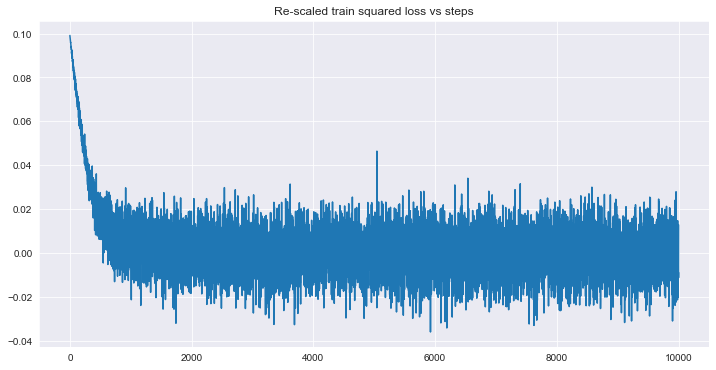

In [22]:
figure = plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(losses)), losses)
plt.title('Re-scaled train squared loss vs steps')
plt.show()

In [23]:
thetas_plus = thetas[:, signs > 0]
thetas_minus = thetas[:, signs < 0]

cs_plus = cs[:, signs > 0]
cs_minus = cs[:, signs < 0]

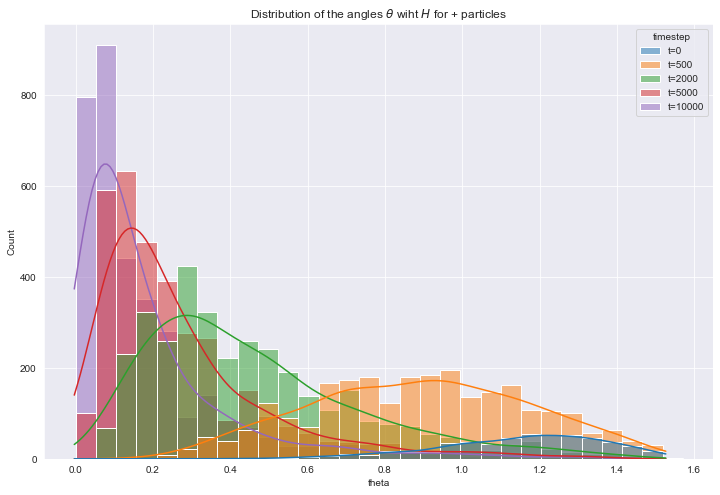

In [24]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_plus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
             multiple='layer', weights='weight')
plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.savefig('/Users/karlhajjar/Downloads/minus_hist.jpg')
plt.show()

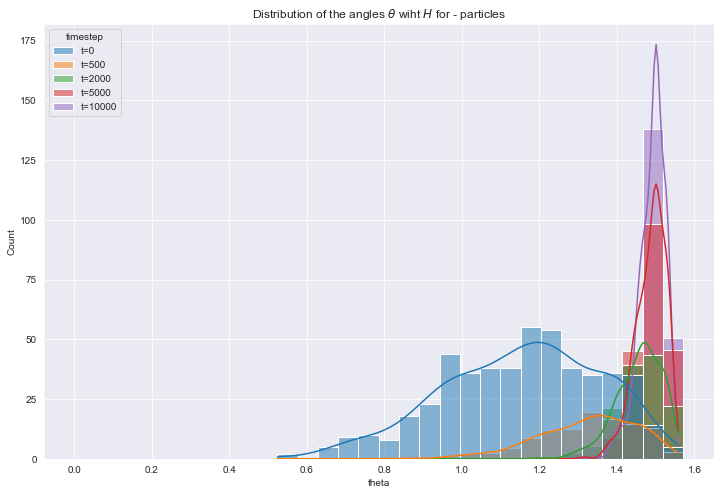

In [25]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
             multiple='layer', weights='weight')
plt.title('Distribution of the angles $\\theta$ wiht $H$ for - particles')
plt.savefig('/Users/karlhajjar/Downloads/plus_hist.jpg')
plt.show()

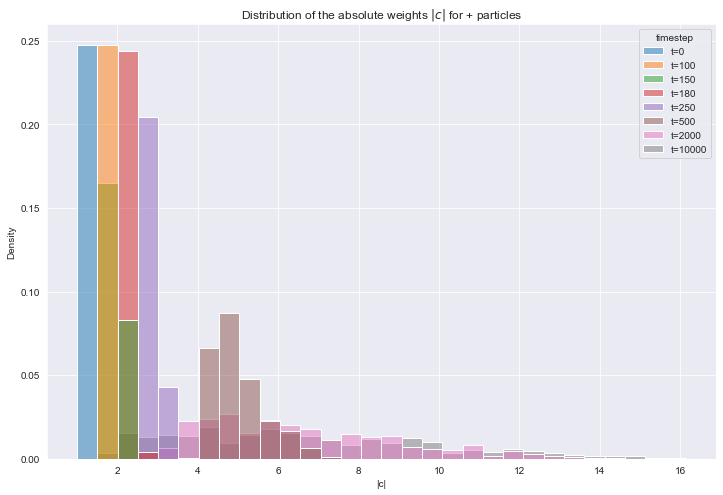

In [26]:
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=30,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for + particles')
plt.show()

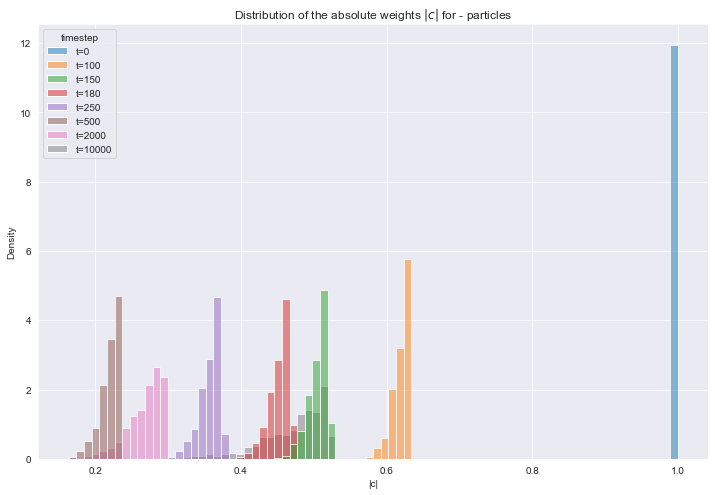

In [27]:
#ts = [0, 50, 100, 150, 180, 250, 300, 500, 1000, 2000, 5000, 8000, 10000]
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_minus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=80,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for - particles')
plt.savefig('/Users/karlhajjar/Downloads/minus_hist.jpg')
plt.show()

In [28]:
cs_plus.shape

(10001, 521)

In [29]:
len(residuals)

10000

In [30]:
cs

DeviceArray([[-1.        ,  1.        , -1.        , ..., -1.        ,
              -1.        , -1.        ],
             [-0.99480885,  1.0049961 , -0.9943095 , ..., -0.9943136 ,
              -0.99488986, -0.9951713 ],
             [-0.9894699 ,  1.0102092 , -0.9885374 , ..., -0.9885453 ,
              -0.98962027, -0.99021393],
             ...,
             [-0.45641702,  6.201977  , -0.3601179 , ..., -0.36113366,
              -0.46912816, -0.52140856],
             [-0.456247  ,  6.2068477 , -0.3599748 , ..., -0.36099032,
              -0.46895462, -0.5212273 ],
             [-0.45649496,  6.207903  , -0.3601573 , ..., -0.3611736 ,
              -0.46921134, -0.5215292 ]], dtype=float32)

In [31]:
np.max(np.mean(cs_plus, axis=-1))

DeviceArray(6.7155433, dtype=float32)

In [32]:
np.mean(np.abs(cs_minus[-1, :]))

0.47236183

In [33]:
np.mean(cs_plus[-1, :])

DeviceArray(6.6348267, dtype=float32)

In [34]:
np.sqrt(np.pi) * s.gamma((d_H + 1)/2) / s.gamma((d_H)/2)

1.5707963267948963

In [35]:
cs_plus

DeviceArray([[ 1.       ,  1.       ,  1.       , ...,  1.       ,
               1.       ,  1.       ],
             [ 1.0049961,  1.0052301,  1.0048229, ...,  1.0051217,
               1.0055791,  1.0057131],
             [ 1.0102092,  1.0106592,  1.00986  , ...,  1.0104578,
               1.011303 ,  1.0115757],
             ...,
             [ 6.201977 ,  8.82218  ,  2.9131272, ...,  7.6958523,
              11.982855 , 13.171281 ],
             [ 6.2068477,  8.829322 ,  2.9149323, ...,  7.70204  ,
              11.992579 , 13.181966 ],
             [ 6.207903 ,  8.831011 ,  2.9148202, ...,  7.703469 ,
              11.994941 , 13.184579 ]], dtype=float32)

In [36]:
cs_plus.shape

(10001, 521)

In [37]:
cs_plus[-1, :].shape

(521,)

In [38]:
m

1024

In [39]:
15.409872 / 3.8656315854718155

3.9863788514960525

In [40]:
6.6348267 / 1.5707963267948963

4.223861863452352